# Age detection

## Data overview

Loading libraries

In [52]:
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

from IPython.display import display, HTML

HOME = os.getcwd()

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
display(HTML('<style>.container { width:90% !important; }</style>'))

The data are taken from the [ChaLearn Looking at People](https://chalearnlap.cvc.uab.es/dataset/26/description/) website. They are located in the `/datasets/faces/` folder

In [53]:
df_path = os.path.join(HOME, 'datasets', 'faces')
display(os.listdir(df_path))

['final_files', 'labels.csv']

In [54]:
image_path = os.path.join(df_path, 'final_files')
image_files = os.listdir(image_path)
display(image_files[:5])

['000000.jpg', '000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg']

In [55]:
path_yandex = 'datasets/faces/labels.csv'
path = 'labels.csv'

if os.path.exists(path):
    labels = pd.read_csv(path)
    display(labels.head())
elif os.path.exists(path_yandex):
    labels = pd.read_csv(path_yandex)
    display(labels.head())
else:
    print('Something is wrong')

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [56]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


**Conclusions**  

We have one folder with all images(`/final_files`) and a `CSV` file `labels.csv` with two columns: `file_name` and `real_age`. The sample is small to estimate the age, only 7591 images, but if necessary, we can increase it by applying augmentation.  

The number of entries in the data frame matches the number of images found in the `final_files` folder. There are no missing values.
The data we are going to work with contains images of people's faces. Thus, to be able to train the model to accurately determine the age of a person in a photo, we need some target variable. This is the information that is contained in the `labels` data frame.

## Exploratory data analysis

Let's move on to studying the images themselves and construct some graphs. First, let's look at the age distribution of the people in the images.

In [43]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


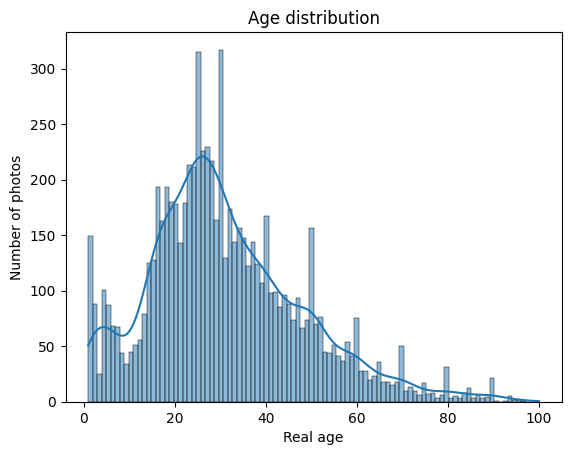

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


In [50]:
sns.histplot(labels['real_age'], bins=100, kde=True)
plt.title('Age distribution', fontsize = 12)
plt.xlabel('Real age')
plt.ylabel('Number of photos')
plt.show()
labels.describe().T

Now let's plot some images. 

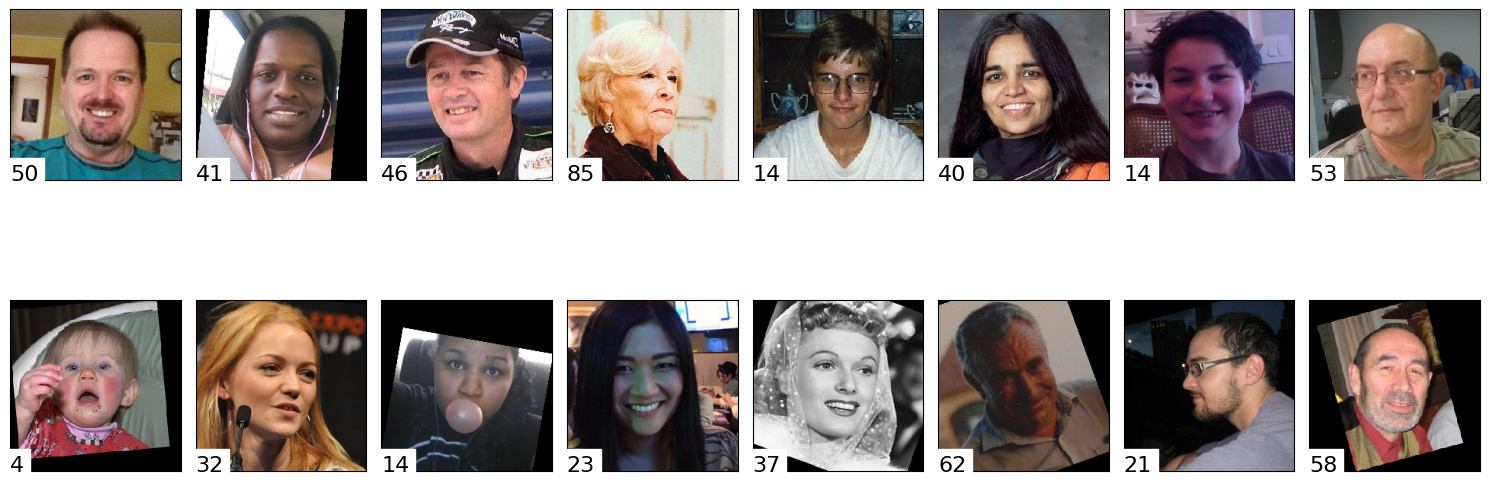

In [51]:
x, y = next(train_gen_flow)
fig = plt.figure(figsize=(15, 10))
for i in range(16):
    ax = fig.add_subplot(2, 8, i+1)
    plt.imshow(x[i])
    plt.text(0, 0, y[i], fontsize = 16, transform=ax.transAxes,
             color='black', backgroundcolor='white')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Conclusions**  

Most of the photos are in the range from 20 to 41 years old. The peak occurs at the age of about 25-30 years. The abnormal age is 88 years or more. There are peaks in age values of 40, 50, 60, etc., perhaps this is due to rounding values if the age of the person in the photo was not known exactly.

The images included in the output are square. All of them depict only the faces of the people located in the center. The general orientation of the photos is about the same - in some photos they are already rotated to align the position of the face, which means we do not need to rotate them, and the initial size of the images is different, due to the fact that visually different photo quality is noticeable, somewhere there are black frames (they do not carry useful information). As a result, we will bring the size of the images to a single size before training the model.

## Training a neural network [GPU]

In this section, we will build a neural network in order to solve the problem. It would take a very long time to train such a model on CPU so we will make use of the GPU server provided by Yandex Practicum and will upload the code there.
These functions will be used in the code to be uploaded to the server and will not thus appear in this notebook 

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras
import pandas as pd 


def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        horizontal_flip=True,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.1,
    )

    return datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=123,
    )


def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123,
    )


def create_model(input_shape):

    backbone = ResNet50(
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        input_shape=input_shape, 
        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.0005), 
                  loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=178, validation_steps=60):

    model.fit(train_data,
        validation_data=test_data,
        epochs=epochs, batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, shuffle=True)
    return model


```

**Description of functions**  

The code consists of the following functions:
* `load_train(path)` - to load the training dataset,
* `load_test(path)` - to load a test dataset,
* `create_model(input_shape)` - to create the network architecture
* `train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps)` - to train the model

In `load_train` we specify the path to the file. The path folder contains a csv file `labels.csv` with two columns `file_name` and `real_age` and a folder with images `/final_files`. We will also add a little data augmentation by including the `horizontal_flip` parameter.

`load_test` looks similar, but without augmentation.

Next we create our model using the `ResNET50` architecture with weights `resnet50_weights_tf_dim_ordering_tf_kernels_notop` as a basis, adding `GlobalAveragePooing2D` and a fully connected layer with one neuron and `ReLU` activation. Also, `Adam` optimization algorithm with `learning_rate=0.0005`, loss function is `MSE`, and metric is `MAE`.

In train_model, we specify the following parameters for training: 
* `epochs=20`
* `steps_per_epoch=178`
* `validation_steps=60` 

This code will be uploaded to the server in a file with the extension `.py`

## Analyzing the trained model

**Result of output model**
```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/20
178/178 - 112s - loss: 211.8198 - mean_absolute_error: 10.8238 - val_loss: 623.7038 - val_mean_absolute_error: 19.8070
Epoch 2/20
178/178 - 91s - loss: 129.2956 - mean_absolute_error: 8.6316 - val_loss: 285.8562 - val_mean_absolute_error: 12.9080
Epoch 3/20
178/178 - 90s - loss: 110.4915 - mean_absolute_error: 7.9498 - val_loss: 309.7344 - val_mean_absolute_error: 12.9707
Epoch 4/20
178/178 - 91s - loss: 99.3810 - mean_absolute_error: 7.5791 - val_loss: 206.3814 - val_mean_absolute_error: 10.8157
Epoch 5/20
178/178 - 90s - loss: 94.1972 - mean_absolute_error: 7.3527 - val_loss: 162.8502 - val_mean_absolute_error: 9.6712
Epoch 6/20
178/178 - 90s - loss: 86.6716 - mean_absolute_error: 7.1263 - val_loss: 111.9558 - val_mean_absolute_error: 8.0735
Epoch 7/20
178/178 - 90s - loss: 78.0427 - mean_absolute_error: 6.7135 - val_loss: 159.0434 - val_mean_absolute_error: 9.4563
Epoch 8/20
178/178 - 90s - loss: 71.3165 - mean_absolute_error: 6.4566 - val_loss: 140.0122 - val_mean_absolute_error: 8.6043
Epoch 9/20
178/178 - 91s - loss: 68.2830 - mean_absolute_error: 6.3106 - val_loss: 156.7435 - val_mean_absolute_error: 9.3912
Epoch 10/20
178/178 - 91s - loss: 68.7876 - mean_absolute_error: 6.3248 - val_loss: 110.7658 - val_mean_absolute_error: 7.8536
Epoch 11/20
178/178 - 91s - loss: 64.9736 - mean_absolute_error: 6.1101 - val_loss: 117.0978 - val_mean_absolute_error: 8.1239
Epoch 12/20
178/178 - 91s - loss: 58.5744 - mean_absolute_error: 5.8082 - val_loss: 98.9291 - val_mean_absolute_error: 7.4024
Epoch 13/20
178/178 - 91s - loss: 57.6907 - mean_absolute_error: 5.8040 - val_loss: 85.4264 - val_mean_absolute_error: 6.8496
Epoch 14/20
178/178 - 91s - loss: 52.1238 - mean_absolute_error: 5.4857 - val_loss: 94.8221 - val_mean_absolute_error: 7.3716
Epoch 15/20
178/178 - 91s - loss: 49.3648 - mean_absolute_error: 5.3715 - val_loss: 107.5696 - val_mean_absolute_error: 7.8255
Epoch 16/20
178/178 - 91s - loss: 45.0125 - mean_absolute_error: 5.1514 - val_loss: 78.9766 - val_mean_absolute_error: 6.6543
Epoch 17/20
178/178 - 91s - loss: 44.1876 - mean_absolute_error: 5.1345 - val_loss: 89.4987 - val_mean_absolute_error: 7.2709
Epoch 18/20
178/178 - 91s - loss: 44.5529 - mean_absolute_error: 5.1227 - val_loss: 87.3414 - val_mean_absolute_error: 6.8330
Epoch 19/20
178/178 - 91s - loss: 40.8609 - mean_absolute_error: 4.9369 - val_loss: 90.3877 - val_mean_absolute_error: 6.8333
Epoch 20/20
178/178 - 90s - loss: 39.5215 - mean_absolute_error: 4.8294 - val_loss: 89.3671 - val_mean_absolute_error: 6.8743

60/60 - 9s - loss: 89.3671 - mean_absolute_error: 6.8743
Test MAE: 6.8743
```

As we can see the metric has improved with each epoch. On the last epoch we obtain the MAE value of *`6.8743`*, which is below the threshold value of 8.

## General conclusions

In this study, we analyzed images of different people whose photos were labeled with age. After conducting exploratory analysis of the data, we wrote a code which, after running on a separate GPU server, showed appropriate learning performance. The use of GPUs and neural networks allows us to process a large amount of information quickly and efficiently with fairly high accuracy. The model with *`ResNet`* architecture pre-trained on the *`Imagenet`* dataset, fine-tuned for the needs of the study, solved the regression problem well, and according to the results obtained, on average the model is wrong by about 7 years.